# Evaluating Convolutional Neural Networks with Fashion-MNIST

In this report I will be developing a convolutional network to classify items of clothing. I will be using the Fashion-MNIST dataset to train and evaluate a convolutional network. Once I have created a model that I believe is sufficiently powerful I will compare its results against two pre-trained networks.

![picture](https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/fashion-mnist-sprite.png?raw=true )


# Convolutional Neural Networks
Convolutional neural networks are a deep learning modal that is almost soly used for computer vision applications. A Convolutional layer uses a filter or kernel that usually has a shape of 3x3 or 5x5 this filter then passes over the image by a determined step. The product at each step is added to the output, essentially downscaling the input (there are methods to prevent this). The process is then repeated by a determined number of filters each filter having different trainable values.

 

![picture](https://miro.medium.com/max/660/1*DTTpGlhwkctlv9CYannVsw.gif)
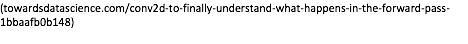

The patterns that a Convolutional layer learns are translation invariant meaning once a pattern has been learnt it can be spotted anywhere learned. They can also learn spatial hierarchies of patterns this means that if you use downscaling through a Convolutional model each successive layer will be learning larger more abstracted patterns made of features from previous layers.

# API's

In [1]:
import tensorflow as tf

from tensorflow import keras

import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from tensorflow import image

import matplotlib.pyplot as plt

from matplotlib import image

import pickle
import PIL
from PIL import Image

from keras.applications import VGG19
from keras.applications import Xception

# Defining the Problem and Assembling a Dataset

Fashion-MNIST is a dataset of clothing item images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. 

| Label | Description |
| ----- | ----------- |
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

 

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)
image lable = 8 = Bag


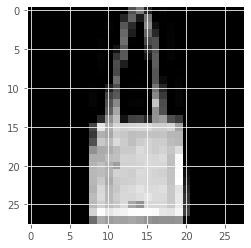

In [4]:
plt.style.use('ggplot')
plt.gray()

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

plt.imshow(x_train[200])

print("image lable = " + str(y_train[200]) + " = " + str(labels[y_train[200]]))

# Choosing a Measure of Success

As the fashion-MNIST was created as a successor to the MNIST dataset it is a single label multiclass classification problem so I will be using ‘categorical_crossentropy’ as my loss function. The optimiser will be ‘adam’ as it has been found to be a more efficient optimisation algorithm on the original MNIST dataset.

![picture](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/05/Comparison-of-Adam-to-Other-Optimization-Algorithms-Training-a-Multilayer-Perceptron.png)

*Comparison of Adam to Other Optimization Algorithms Training a Multilayer Perceptron
Taken from Adam: A Method for Stochastic Optimization, 2015*



```
model.compile(optimizer='adam',

​            loss='categorical_crossentropy',

​            metrics=['accuracy'])
```





# Data Prepossessing 

I will be normalising the data to a smaller scale by converting the data type to ‘float32’ and dividing the values by 255 as this will prevent overly large weight updates and reshape the image array to include a channel dimension giving it the form (image_height, image_width, image_channel). The label’s will be one hot encoded using the to_categorical function.

In [5]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print("x_train shape = " + str(x_train.shape))

print("y_train shape = " + str(y_train.shape))

print("lable = " + str(y_train[2]))

x_train shape = (60000, 28, 28, 1)
y_train shape = (60000, 10)
lable = [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Evaluating

I will Removing the first 10,000 images from the test data to form a validation set. this set will be used to evaluate the model after every epoch when training this will help to identify overfitting.

In [6]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]
print(x_val.shape)
print(partial_x_train.shape)

(10000, 28, 28, 1)
(50000, 28, 28, 1)


# Densely connected Classifier 
I will use a dense two-layer classifier the first with 'relu' activation and the second with 'softmax' as this is a multiclass, single lable problem. I will also experiment with a different number of units in the top 'relu' activated layer.


```
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
```



# Developing a Model

## Functions 
I have designed functions for building models and for displaying results.

### Functions for displaying graphs

In [7]:
#  plots the results of a history object 
def plt_hist(hist, type):
  keys = list(hist.keys())
  for i in range(len(keys)):
    net_a = keys[i]
    plt_comparison(hist[net_a]['val_' + type], hist[net_a][type], type, 'val_' + net_a, net_a)

# plots two np.arrays 
def plt_comparison(a, b, type, lable_a, lable_b):
  epochs = range(1, len(a) + 1)

  plt.plot(epochs, a, 'b+', label = lable_a)
  plt.plot(epochs, b, 'bo', label = lable_b)
  plt.xlabel('Epochs')
  plt.ylabel(type)
  plt.title(lable_a + '/' + lable_b)
  plt.legend()
  plt.show()

# plots the optimal results fro multiple history objects
def plt_opt_hist(hist, name):
    loss = []
    acc = []
    keys = list(hist.keys())
    l = len(keys)
    for i in range(l):
      loss.append(min(hist[keys[i]]['val_loss']))
      acc.append(max(hist[keys[i]]['val_acc']))

    plt.plot(range(1,l+1), loss, 'b', label = 'loss')
    plt.title('Minimum loss at ' + name)
    plt.xlabel(name)
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(range(1,l+1), acc, 'b', label = 'acc')
    plt.title('Maximum acc at ' + name)
    plt.xlabel(name)
    plt.ylabel('acc')
    plt.legend()
    plt.show()

# displays the optimal result and model name from multiple history objects
def dis_opt_results(hist):
  keys = list(hist.keys())
  l = len(keys)
  min_loss = min(hist[keys[0]]['val_loss'])
  min_name = keys[0]
  max_acc = max(hist[keys[0]]['val_acc'])
  max_name = keys[0]
  # loss = []
  # acc = []
  for i in range(l):
    if min(hist[keys[i]]['val_loss']) < min_loss:
      min_loss = min(hist[keys[i]]['val_loss'])
      min_name = keys[i]
    if max(hist[keys[i]]['val_acc']) > max_acc:
      max_acc = max(hist[keys[i]]['val_acc'])
      max_name = keys[i]

  print('optimal loss = ' + str(min_loss) + ' at ' + min_name)
  print('optimal acc = ' + str(max_acc) + ' at ' + max_name)

#  merges two dictionary objects
def merge_two_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z

### Functions for building/testing models

In [8]:
# a function that takes as input the layers and values for a model in the form of np.arrays and outputs a model of that configuration
def build_model(filter, max_pooling, add_dropout, input, dence, model_name):
    model = Sequential(name=model_name)
    
    model.add(Conv2D(filters=filter[0], kernel_size=3, padding='same', activation='relu', input_shape=input))
    if max_pooling[0] == 1:
      model.add(MaxPooling2D(pool_size=2)) 
    if add_dropout[0] > 0:
          model.add(Dropout(add_dropout[0])) 
    
    if len(filter)>1:
      for x in range(1,len(filter)):
        model.add(Conv2D(filters=filter[x], kernel_size=3, padding='same', activation='relu')) 
        if max_pooling[x] == 1:
          model.add(MaxPooling2D(pool_size=2))
        if add_dropout[x] > 0:
          model.add(Dropout(add_dropout[x])) 
    
    model.add(Flatten())

    for y in dence:
      model.add(Dense(y, activation='relu'))
    
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['acc']) 
    return model

#  a function that builds multiple models prints there summarys 
def models_summary(model_layers, max_pooling, add_dropout, input_size, num_epochs, dence_units, batch, name):
  count = 0
  for x in range(max(len(model_layers),len(dence_units))):
    count = count + 1
    model_name =  name + '_model-' + str(count)
    model = build_model(model_layers[x], max_pooling[x], add_dropout[x], input_size, dence_units[x], model_name)
    model.summary()

# a function that builds and trains multiple models. the models and histories are then saved to disc
def train_models(model_layers, max_pooling, add_dropout, input_size, num_epochs, dence_units, batch, name):
  histories = {}
  count = 0
  for x in range(len(model_layers)):
    count = count+1
    model_name =  name + '_model-' + str(count)
    model = build_model(model_layers[x], max_pooling[x], add_dropout[x], input_size, dence_units[x], model_name)
    print('Training', model_name)
    history = model.fit(partial_x_train, 
            partial_y_train,
            epochs=num_epochs,
            batch_size= batch,
            validation_data = (x_val, y_val))
    histories[model_name] = (history.history)
    model.save('models/' + model_name + '.h5')
  np.save('results/' + name + '.npy', histories) 


# Scaling up: Developing a Model That Overfits

## Low Capacity Model

as the input shape of each feature is small only (28, 28, 1) I will use padding to avoid downscaling at the Conv2D layers. 

In [11]:
name = 'low_cap'
model_layers = [[32]]
add_max_pooling = [[1]]
add_dropout = [[0]]
input_size = (28,28,1)
num_epochs = 20
dence_units = [[64]]
batch_size = 512
models_summary(model_layers, add_max_pooling, add_dropout, input_size, num_epochs, dence_units, batch_size, name)

Model: "low_cap_model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                401472    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 402,442
Trainable params: 402,442
Non-trainable params: 0
_________________________________________________________________


In [12]:
train_models(model_layers, add_max_pooling, add_dropout, input_size, num_epochs, dence_units, batch_size, name)

Training low_cap_model-1
Epoch 1/20
98/98 [==============================] - 22s 221ms/step - loss: 1.0374 - acc: 0.6617 - val_loss: 0.4306 - val_acc: 0.8490
Epoch 2/20
98/98 [==============================] - 25s 252ms/step - loss: 0.4168 - acc: 0.8549 - val_loss: 0.3663 - val_acc: 0.8741
Epoch 3/20
98/98 [==============================] - 26s 267ms/step - loss: 0.3566 - acc: 0.8753 - val_loss: 0.3415 - val_acc: 0.8853
Epoch 4/20
98/98 [==============================] - 27s 277ms/step - loss: 0.3295 - acc: 0.8836 - val_loss: 0.3253 - val_acc: 0.8899
Epoch 5/20
98/98 [==============================] - 26s 270ms/step - loss: 0.3006 - acc: 0.8950 - val_loss: 0.3046 - val_acc: 0.8981
Epoch 6/20
98/98 [==============================] - 25s 258ms/step - loss: 0.2812 - acc: 0.9007 - val_loss: 0.2926 - val_acc: 0.9009
Epoch 7/20
98/98 [==============================] - 29s 293ms/step - loss: 0.2697 - acc: 0.9041 - val_loss: 0.2825 - val_acc: 0.9020
Epoch 8/20
98/98 [==========================

### Results

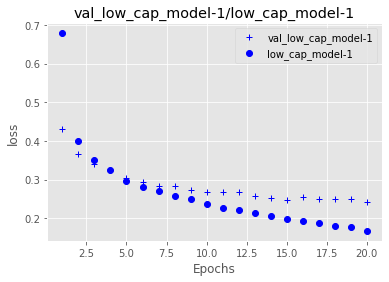

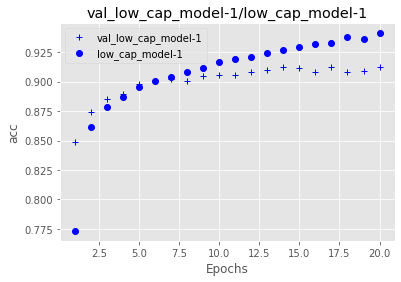

In [15]:
low_cap_hist = np.load('results/low_cap.npy',allow_pickle='TRUE').item()
plt_hist(low_cap_hist, 'loss')
plt_hist(low_cap_hist, 'acc')

In [16]:
dis_opt_results(low_cap_hist)

optimal loss = 0.24230849742889404 at low_cap_model-1
optimal acc = 0.9128000140190125 at low_cap_model-1


the low capacity model performs well with a validation accuracy of 91.2%. I will scale up the model to see if it can be improved.

## Covnet2D layers/maxPooling layers

### Conv2D layers 1,2,3 with maxPooling at layer 1

In [17]:
name = 'layers'
model_layers = [[32, 32], [32, 32, 32]]
add_max_pooling = [[1,0],[1,0,0]]
add_dropout = [[0, 0], [0, 0, 0]]
input_size = (28,28,1)
num_epochs = 20
dence_units = [[64],[64]]
batch_size = 512
models_summary(model_layers, add_max_pooling, add_dropout, input_size, num_epochs, dence_units, batch_size, name)

Model: "layers_model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
flatten_7 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                401472    
_________________________________________________________________
dense_15 (Dense)             (None, 10)                650       
Total params: 411,690
Trainable params: 411,690
Non-trainable params: 0
______________________________________________

In [18]:
train_models(model_layers, add_max_pooling, add_dropout, input_size, num_epochs, dence_units, batch_size, name)

Training layers_model-1
Epoch 1/20
98/98 [==============================] - 69s 708ms/step - loss: 1.0451 - acc: 0.6501 - val_loss: 0.4326 - val_acc: 0.8495
Epoch 2/20
98/98 [==============================] - 72s 730ms/step - loss: 0.4174 - acc: 0.8541 - val_loss: 0.3719 - val_acc: 0.8718
Epoch 3/20
98/98 [==============================] - 66s 675ms/step - loss: 0.3624 - acc: 0.8719 - val_loss: 0.3382 - val_acc: 0.8835
Epoch 4/20
98/98 [==============================] - 63s 647ms/step - loss: 0.3318 - acc: 0.8829 - val_loss: 0.3203 - val_acc: 0.8884
Epoch 5/20
98/98 [==============================] - 63s 640ms/step - loss: 0.3073 - acc: 0.8888 - val_loss: 0.3049 - val_acc: 0.8930
Epoch 6/20
98/98 [==============================] - 68s 693ms/step - loss: 0.2842 - acc: 0.8989 - val_loss: 0.2905 - val_acc: 0.8988
Epoch 7/20
98/98 [==============================] - 72s 739ms/step - loss: 0.2694 - acc: 0.9024 - val_loss: 0.2768 - val_acc: 0.9023
Epoch 8/20
98/98 [===========================

### Results

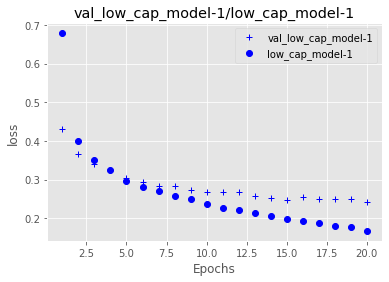

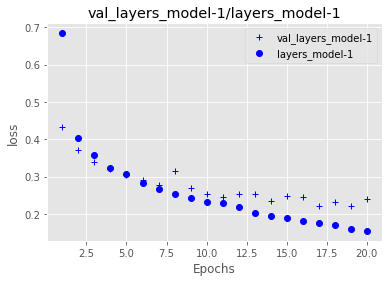

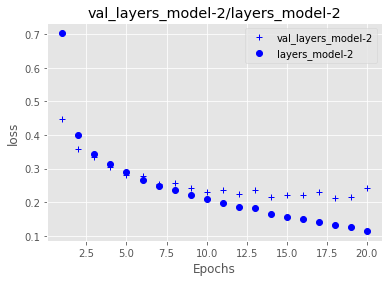

In [17]:
layers_hist = np.load('results/layers.npy',allow_pickle='TRUE').item()
layers_hist = merge_two_dicts(low_cap_hist, layers_hist)
plt_hist(layers_hist, 'loss')

We can see that the validation loss plateaus at around the 10th epochs. none of these models are showing signs of overfitting.

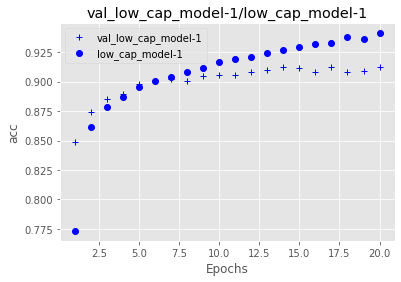

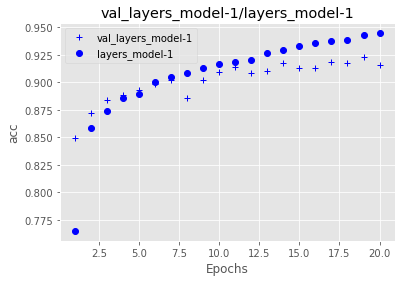

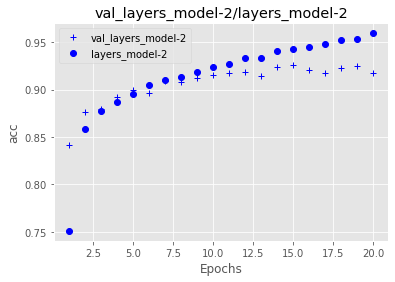

In [20]:
plt_hist(layers_hist, 'acc')

Similarly, the validation accuracy plateaus at around the 10th epoch. none of these models are showing signs of overfitting.

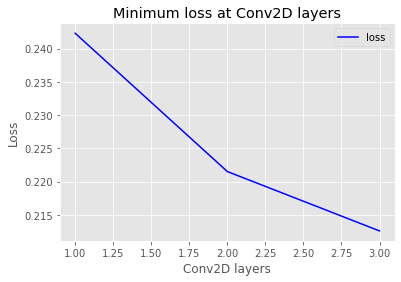

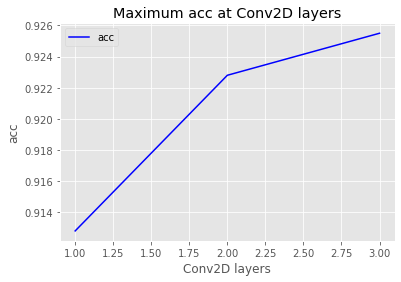

In [21]:
plt_opt_hist(layers_hist, 'Conv2D layers')

In [20]:
dis_opt_results(layers_hist)

optimal loss = 0.21257780492305756 at layers_model-2
optimal acc = 0.9254999756813049 at layers_model-2


The model 'layers_model-2' with three convolutional layers has shows the best performance in both loss and accuracy.

### Conv2D layers 1,2,3 with maxPooling at layers 1 and 2

In [22]:
name = 'layers_2'
model_layers = [[32, 32], [32, 32, 32]]
add_max_pooling = [[1,1],[1,1,0]]
add_dropout = [[0, 0], [0, 0, 0]]
input_size = (28,28,1)
num_epochs = 20
dence_units = [[64],[64]]
batch_size = 512
models_summary(model_layers, add_max_pooling, add_dropout, input_size, num_epochs, dence_units, batch_size, name)

Model: "layers_2_model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1568)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                100416    
_________________________________________________________________
dense_23 (Dense)             (None, 10)           

In [23]:
train_models(model_layers, add_max_pooling, add_dropout, input_size, num_epochs, dence_units, batch_size, name)

Training layers_2_model-1
Epoch 1/20
98/98 [==============================] - 68s 688ms/step - loss: 1.2459 - acc: 0.5758 - val_loss: 0.5108 - val_acc: 0.8208
Epoch 2/20
98/98 [==============================] - 64s 651ms/step - loss: 0.4874 - acc: 0.8239 - val_loss: 0.4303 - val_acc: 0.8512
Epoch 3/20
98/98 [==============================] - 68s 691ms/step - loss: 0.4087 - acc: 0.8549 - val_loss: 0.3848 - val_acc: 0.8646
Epoch 4/20
98/98 [==============================] - 87s 889ms/step - loss: 0.3692 - acc: 0.8675 - val_loss: 0.3670 - val_acc: 0.8737
Epoch 5/20
98/98 [==============================] - 76s 775ms/step - loss: 0.3492 - acc: 0.8749 - val_loss: 0.3409 - val_acc: 0.8831
Epoch 6/20
98/98 [==============================] - 69s 710ms/step - loss: 0.3282 - acc: 0.8823 - val_loss: 0.3453 - val_acc: 0.8775
Epoch 7/20
98/98 [==============================] - 74s 757ms/step - loss: 0.3129 - acc: 0.8891 - val_loss: 0.3404 - val_acc: 0.8802
Epoch 8/20
98/98 [=========================

### Results

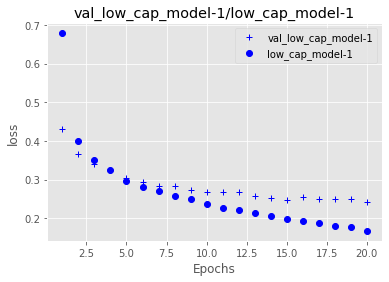

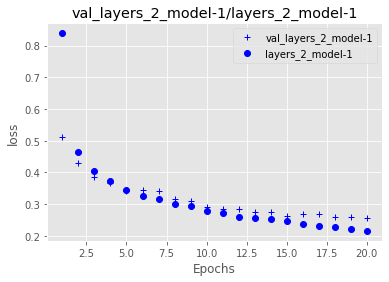

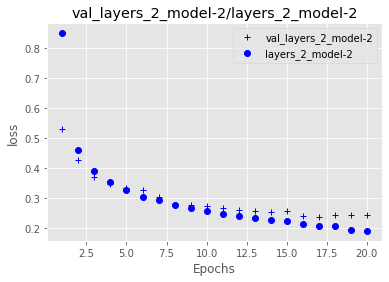

In [22]:
layers_2_hist = np.load('results/layers_2.npy',allow_pickle='TRUE').item()
layers_2_hist = merge_two_dicts(low_cap_hist, layers_2_hist)
plt_hist(layers_2_hist, 'loss')

We can see that there is little to no overfitting in any of the models. the validation loss plateaus at around the 10th epoch.

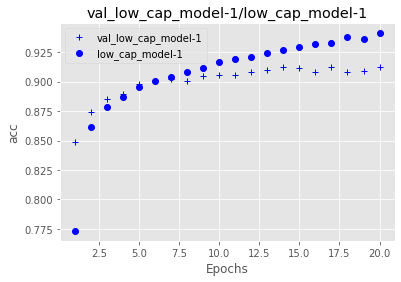

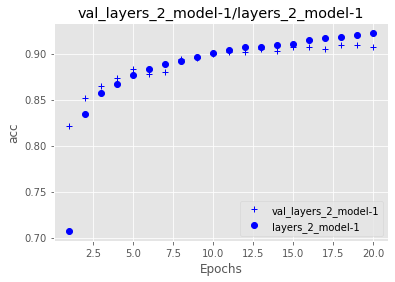

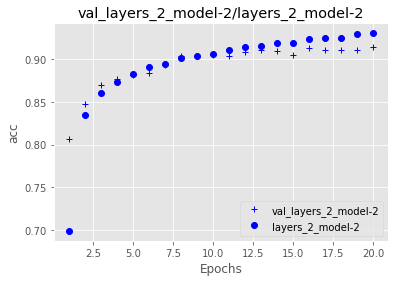

In [23]:
plt_hist(layers_2_hist, 'acc')

Similarly, the accuracy plateaus at around the 10th epoch on all models.

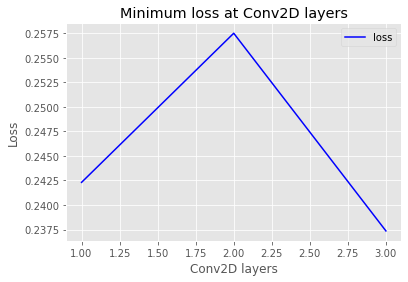

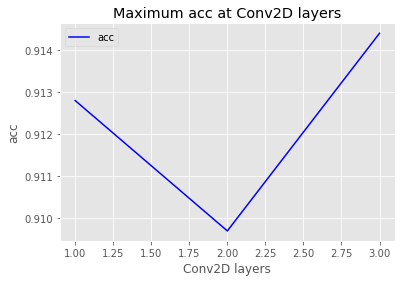

In [24]:
plt_opt_hist(layers_2_hist, 'Conv2D layers')

In [25]:
dis_opt_results(layers_2_hist)

optimal loss = 0.2373621165752411 at layers_2_model-2
optimal acc = 0.9143999814987183 at layers_2_model-2


Again the model with three convolutional layers performs the best in loss and accuracy.

### Conv2D layers 1,2,3 with maxPooling at layers 1, 2 and 3

In [27]:
name = 'layers_3'
model_layers = [[32, 32, 32]]
add_max_pooling = [[1,1,1]]
add_dropout = [[0, 0, 0]]
input_size = (28,28,1)
num_epochs = 20
dence_units = [[64]]
batch_size = 512
models_summary(model_layers, add_max_pooling, add_dropout, input_size, num_epochs, dence_units, batch_size, name)

Model: "layers_3_model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 288)          

In [28]:
train_models(model_layers, add_max_pooling, add_dropout, input_size, num_epochs, dence_units, batch_size, name)

Training layers_3_model-1
Epoch 1/20
98/98 [==============================] - 77s 779ms/step - loss: 1.4999 - acc: 0.5276 - val_loss: 0.6085 - val_acc: 0.7674
Epoch 2/20
98/98 [==============================] - 74s 759ms/step - loss: 0.5718 - acc: 0.7900 - val_loss: 0.4904 - val_acc: 0.8245
Epoch 3/20
98/98 [==============================] - 75s 761ms/step - loss: 0.4585 - acc: 0.8353 - val_loss: 0.4088 - val_acc: 0.8536
Epoch 4/20
98/98 [==============================] - 75s 760ms/step - loss: 0.4000 - acc: 0.8562 - val_loss: 0.3870 - val_acc: 0.8620
Epoch 5/20
98/98 [==============================] - 74s 755ms/step - loss: 0.3646 - acc: 0.8705 - val_loss: 0.3464 - val_acc: 0.8771
Epoch 6/20
98/98 [==============================] - 75s 769ms/step - loss: 0.3417 - acc: 0.8761 - val_loss: 0.3425 - val_acc: 0.8770
Epoch 7/20
98/98 [==============================] - 74s 755ms/step - loss: 0.3293 - acc: 0.8788 - val_loss: 0.3202 - val_acc: 0.8866
Epoch 8/20
98/98 [=========================

### Results

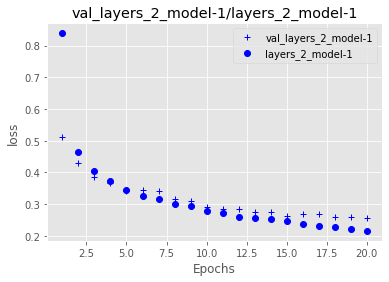

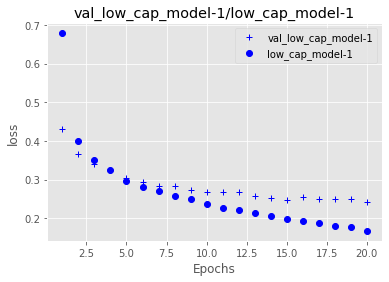

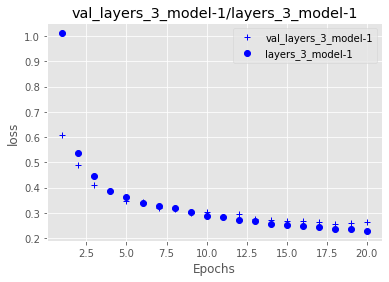

In [26]:
layers_3_hist = np.load('results/layers_3.npy',allow_pickle='TRUE').item()
temp = {k: layers_2_hist[k] for k in layers_2_hist.keys() - {'layers_2_model-2'}}
layers_3_hist = merge_two_dicts(temp, layers_3_hist)
plt_hist(layers_3_hist, 'loss')

Again there are no signs of over fitting especially in the three layer model where the training and validation loss is almost identical until the 15th epoch.

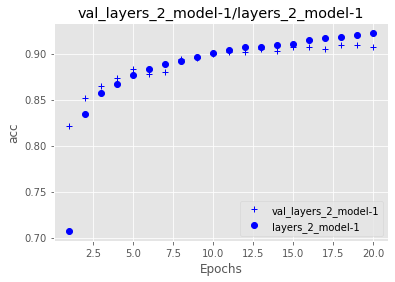

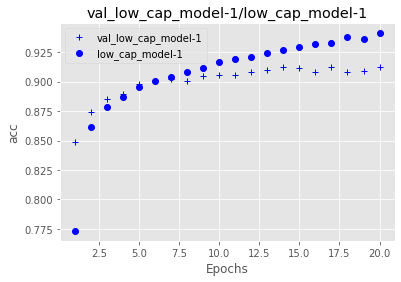

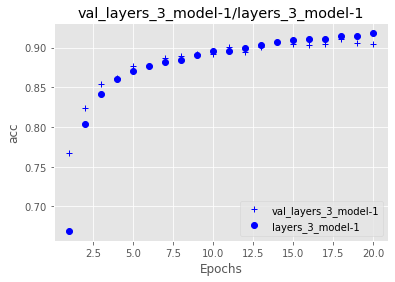

In [30]:
plt_hist(layers_3_hist, 'acc')

With accuracy as well the test and validation are the same all the way up to the 20th epoch.

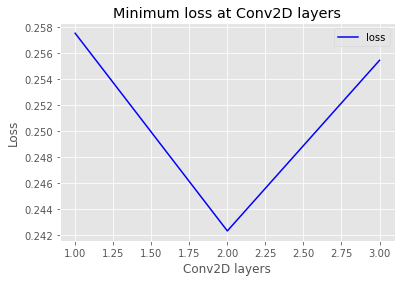

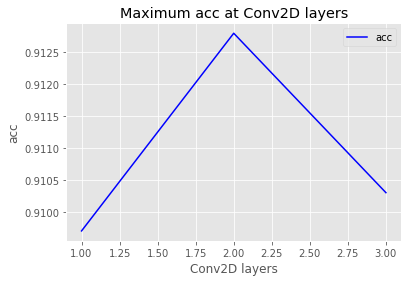

In [31]:
plt_opt_hist(layers_3_hist, 'Conv2D layers')

However, we can see there is a significant drop-off in loss and accuracy at the three layer model.

In [28]:
final = merge_two_dicts(layers_hist, layers_2_hist)
final = merge_two_dicts(final, layers_3_hist)
dis_opt_results(final)

optimal loss = 0.21257780492305756 at layers_model-2
optimal acc = 0.9254999756813049 at layers_model-2


the model 'layers_model-2' with three convolutional layers and one maxPooling layer shows the best performance overall achieving an accuracy of 92.5% on the validation set.

In [33]:
keras.models.load_model('models/layers_model-2.h5').summary()

Model: "layers_model-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
flatten_10 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                401472    
_________________________________________________________________
dense_21 (Dense)             (None, 10)             

I will be using this configuration going forward.

## Dence clasifier units


In [34]:
name = 'Dence_units'
model_layers = [[32, 32, 32], [32, 32, 32], [32, 32, 32], [32, 32, 32], [32, 32, 32]]
add_max_pooling = [[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0]]
dropout = [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
input_size = (28,28,1)
num_epochs = 20
dence_units = [[64, 64], [128], [128, 64], [128, 128], [512]]
batch_size = 512
models_summary(model_layers, add_max_pooling, dropout, input_size, num_epochs, dence_units, batch_size, name)

Model: "Dence_units_model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
flatten_17 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                401472    
_________________________________________________________________
dense_35 (Dense)             (None, 64)        

In [35]:
train_models(model_layers, add_max_pooling, dropout, input_size, num_epochs, dence_units, batch_size, name)

Training Dence_units_model-1
Epoch 1/20
98/98 [==============================] - 105s 1s/step - loss: 1.1886 - acc: 0.5904 - val_loss: 0.4625 - val_acc: 0.8372
Epoch 2/20
98/98 [==============================] - 104s 1s/step - loss: 0.4305 - acc: 0.8443 - val_loss: 0.3728 - val_acc: 0.8716
Epoch 3/20
98/98 [==============================] - 104s 1s/step - loss: 0.3548 - acc: 0.8745 - val_loss: 0.3245 - val_acc: 0.8858
Epoch 4/20
98/98 [==============================] - 103s 1s/step - loss: 0.3125 - acc: 0.8895 - val_loss: 0.3284 - val_acc: 0.8775
Epoch 5/20
98/98 [==============================] - 102s 1s/step - loss: 0.3025 - acc: 0.8919 - val_loss: 0.2854 - val_acc: 0.8988
Epoch 6/20
98/98 [==============================] - 104s 1s/step - loss: 0.2681 - acc: 0.9033 - val_loss: 0.2705 - val_acc: 0.9028
Epoch 7/20
98/98 [==============================] - 111s 1s/step - loss: 0.2523 - acc: 0.9095 - val_loss: 0.2694 - val_acc: 0.9030
Epoch 8/20
98/98 [==============================] - 10

### Results

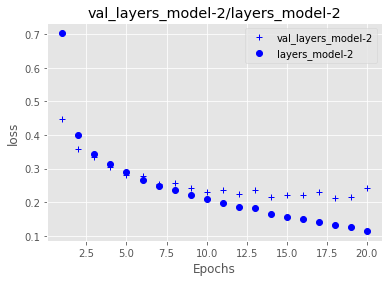

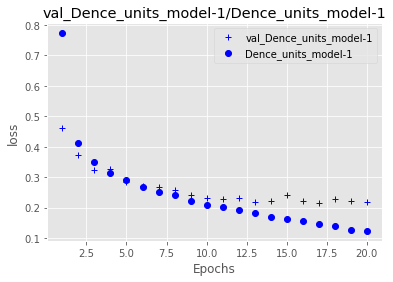

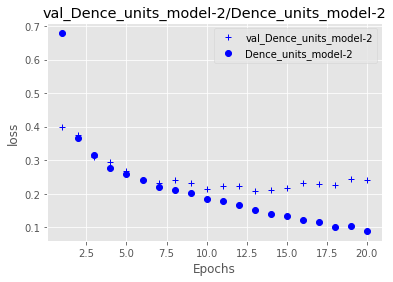

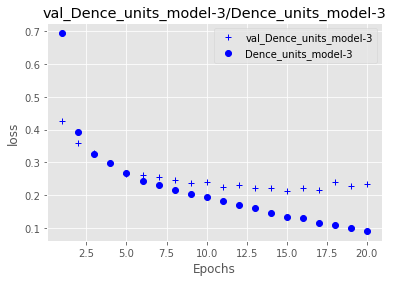

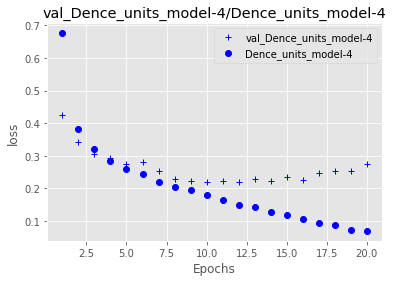

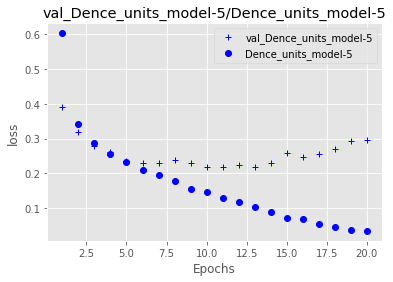

In [27]:
dence_units_hist = np.load('results/Dence_units.npy',allow_pickle='TRUE').item()
temp = {k: layers_hist[k] for k in layers_hist.keys() - {'low_cap_model-1', 'layers_model-1'}}
temp.keys()
dence_units_hist = merge_two_dicts(temp, dence_units_hist)
plt_hist(dence_units_hist, 'loss')

The validation loss begins to plateau at around the 7th epoch on all models and begin to overfit at around the 16th epoch on the last two models.

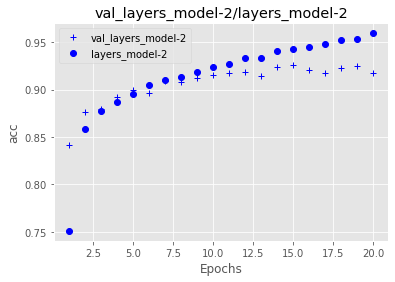

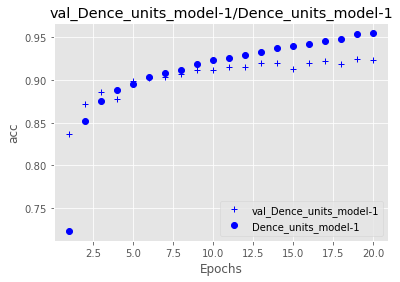

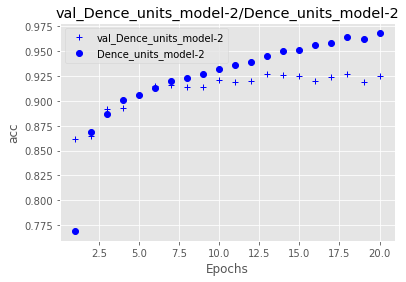

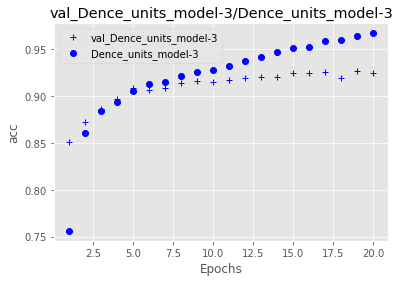

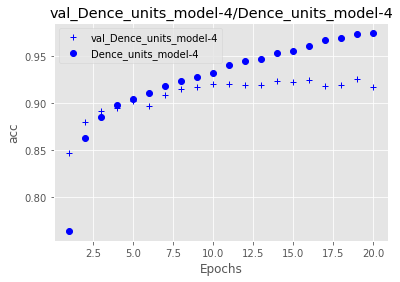

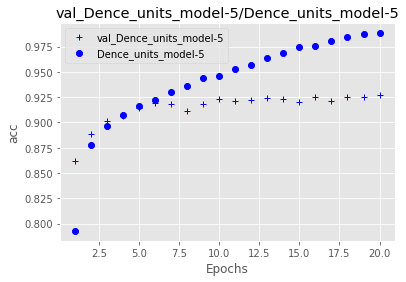

In [37]:
plt_hist(dence_units_hist, 'acc')

the accuracy of all models plateau at around the 7th epoch.

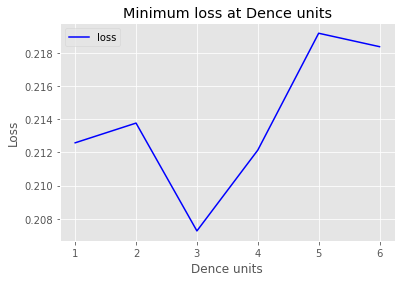

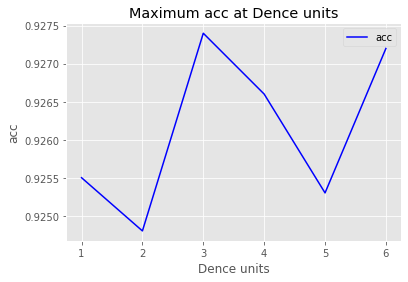

In [47]:
plt_opt_hist(dence_units_hist, 'Dence units')

In [39]:
dis_opt_results(dence_units_hist)

optimal loss = 0.20726720988750458 at Dence_units_model-2
optimal acc = 0.9273999929428101 at Dence_units_model-2


The model 'Dence_units_model-2' with one dense layer and 128 units has the best performance with a validation accuracy of 92.7%. I will be using this dense classifier going forward.



In [52]:
keras.models.load_model('models/dence_units_model-2.h5').summary()

Model: "Dence_units_model-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
flatten_23 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 128)               802944    
_________________________________________________________________
dense_51 (Dense)             (None, 10)        

I will be using this configuratin going forward.

## Covnet2D filters

In [58]:
name = 'filters'
model_layers = [[64, 64, 64], [128, 128, 128]]
add_max_pooling = [[1, 0, 0], [1, 0, 0]]
dropout = [[0, 0, 0], [0, 0, 0]]
input_size = (28,28,1)
num_epochs = 20
dence_units = [[128], [128]]
batch_size = 512
models_summary(model_layers, add_max_pooling, dropout, input_size, num_epochs, dence_units, batch_size, name)

Model: "filters_model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_126 (Conv2D)          (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 14, 14, 64)        36928     
_________________________________________________________________
flatten_52 (Flatten)         (None, 12544)             0         
_________________________________________________________________
dense_117 (Dense)            (None, 128)               1605760   
_________________________________________________________________
dense_118 (Dense)            (None, 10)            

In [59]:
train_models(model_layers, add_max_pooling, dropout, input_size, num_epochs, dence_units, batch_size, name)

Training filters_model-1
Epoch 1/20
98/98 [==============================] - 227s 2s/step - loss: 0.9683 - acc: 0.6612 - val_loss: 0.3792 - val_acc: 0.8653
Epoch 2/20
98/98 [==============================] - 292s 3s/step - loss: 0.3612 - acc: 0.8709 - val_loss: 0.3034 - val_acc: 0.8906
Epoch 3/20
98/98 [==============================] - 263s 3s/step - loss: 0.2843 - acc: 0.8958 - val_loss: 0.2891 - val_acc: 0.8960
Epoch 4/20
98/98 [==============================] - 273s 3s/step - loss: 0.2508 - acc: 0.9065 - val_loss: 0.2548 - val_acc: 0.9068
Epoch 5/20
98/98 [==============================] - 264s 3s/step - loss: 0.2258 - acc: 0.9178 - val_loss: 0.2548 - val_acc: 0.9067
Epoch 6/20
98/98 [==============================] - 263s 3s/step - loss: 0.2100 - acc: 0.9234 - val_loss: 0.2371 - val_acc: 0.9118
Epoch 7/20
98/98 [==============================] - 263s 3s/step - loss: 0.1786 - acc: 0.9326 - val_loss: 0.2221 - val_acc: 0.9174
Epoch 8/20
98/98 [==============================] - 265s 3

### Results

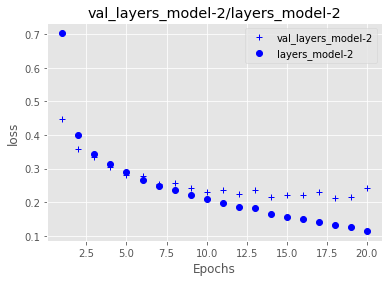

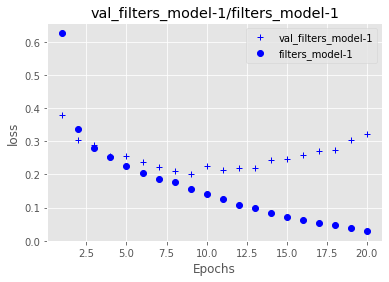

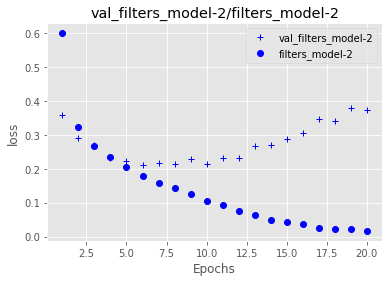

In [63]:
filters_hist = np.load('results/filters.npy',allow_pickle='TRUE').item()
temp = {k: layers_hist[k] for k in layers_hist.keys() - {'low_cap_model-1', 'layers_model-1'}}
filters_hist = merge_two_dicts(temp, filters_hist)
plt_hist(filters_hist, 'loss')

The last two models begin to overfit at around the 12th epoch.

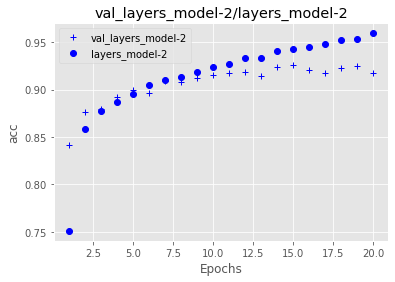

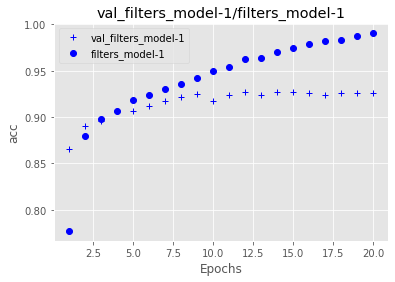

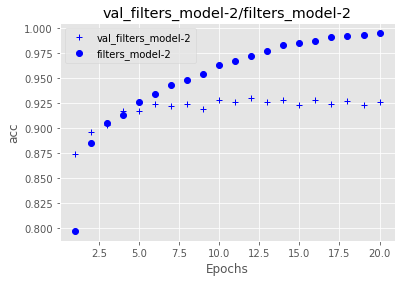

In [64]:
plt_hist(filters_hist, 'acc')

The validation accuracy stops improving at around the 10th epoch in the first model. this begins earlier at around the 7th epoch on the second two models.

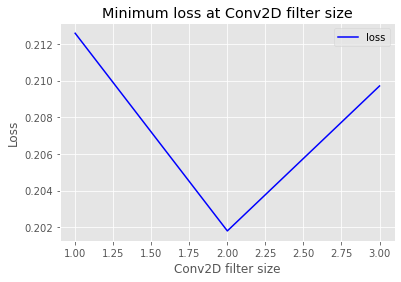

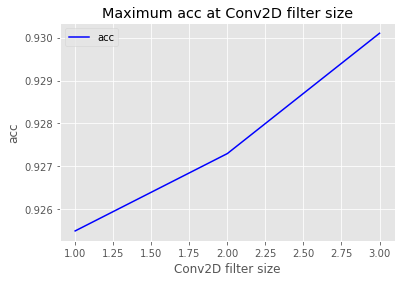

In [65]:
plt_opt_hist(filters_hist, 'Conv2D filter size')

The third model performs the best seedily increasing with the size of the filter however there is an increase of loss in the last model.

In [70]:
dis_opt_results(filters_hist)

optimal loss = 0.20179790258407593 at filters_model-1
optimal acc = 0.9301000237464905 at filters_model-2


The model 'filters_model-2' with a filter 128 filters at every convolutional layer has the best performance with a validation accuracy of 93%.

In [71]:
keras.models.load_model('models/filters_model-2.h5').summary()

Model: "filters_model-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_135 (Conv2D)          (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 14, 14, 128)       147584    
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 14, 14, 128)       147584    
_________________________________________________________________
flatten_55 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_123 (Dense)            (None, 128)               3211392   
_________________________________________________________________
dense_124 (Dense)            (None, 10)            

 I will be using this configuration going forward.

## Dropout

In [72]:
name = 'dropout'
model_layers = [[128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128]]
add_max_pooling = [[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0]]
dropout = [[0.3, 0, 0], [0.5, 0, 0], [0.3, 0.3, 0], [0.5, 0.5, 0], [0.3, 0.3, 0.3], [0.5, 0.5, 0.5]]
input_size = (28,28,1)
num_epochs = 20
dence_units = [[128], [128], [128], [128], [128], [128]]
batch_size = 512
models_summary(model_layers, add_max_pooling, dropout, input_size, num_epochs, dence_units, batch_size, name)

Model: "dropout_model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_159 (Conv2D)          (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 14, 14, 128)       147584    
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 14, 14, 128)       147584    
_________________________________________________________________
flatten_63 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_139 (Dense)            (None, 128)           

In [73]:
train_models(model_layers, add_max_pooling, dropout, input_size, num_epochs, dence_units, batch_size, name)

Training dropout_model-1
Epoch 1/20
98/98 [==============================] - 1006s 10s/step - loss: 0.8924 - acc: 0.6728 - val_loss: 0.3424 - val_acc: 0.8815
Epoch 2/20
98/98 [==============================] - 1320s 13s/step - loss: 0.3323 - acc: 0.8809 - val_loss: 0.2766 - val_acc: 0.9030
Epoch 3/20
98/98 [==============================] - 1184s 12s/step - loss: 0.2634 - acc: 0.9039 - val_loss: 0.2529 - val_acc: 0.9094
Epoch 4/20
98/98 [==============================] - 1419s 14s/step - loss: 0.2313 - acc: 0.9170 - val_loss: 0.2329 - val_acc: 0.9140
Epoch 5/20
98/98 [==============================] - 1413s 14s/step - loss: 0.2027 - acc: 0.9263 - val_loss: 0.2351 - val_acc: 0.9116
Epoch 6/20
98/98 [==============================] - 1215s 12s/step - loss: 0.1753 - acc: 0.9348 - val_loss: 0.2196 - val_acc: 0.9222
Epoch 7/20
98/98 [==============================] - 1198s 12s/step - loss: 0.1587 - acc: 0.9426 - val_loss: 0.2136 - val_acc: 0.9237
Epoch 8/20
98/98 [==========================

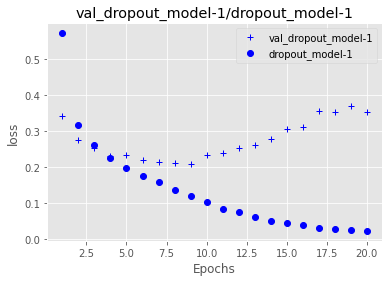

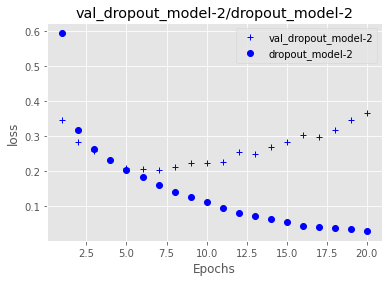

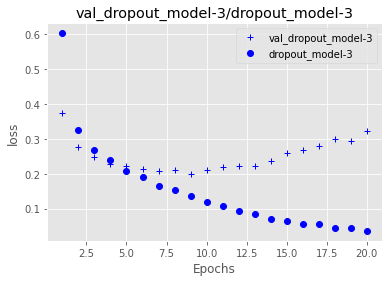

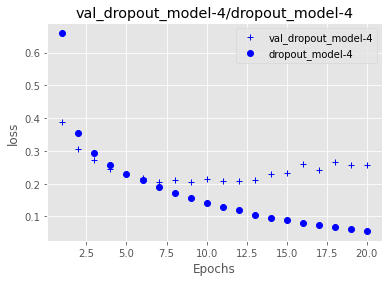

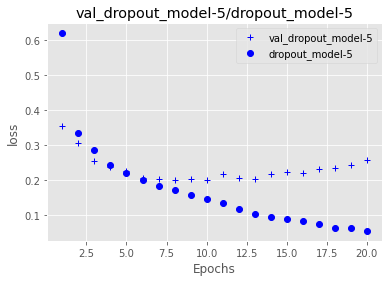

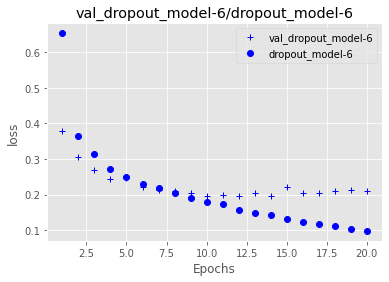

In [74]:
dropout_hist = np.load('results/dropout.npy',allow_pickle='TRUE').item()
plt_hist(dropout_hist, 'loss')

We can see that including a low number of dropout layers actually increases overfitting. however, including more dropout layers then helps to controlee this overfitting. Having a higher frequency for each dropout layer also helps to regularise training.

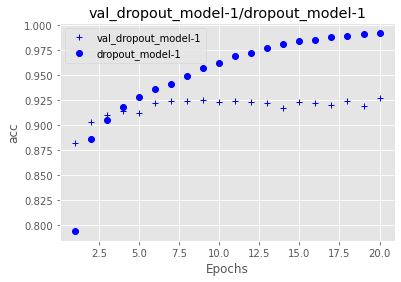

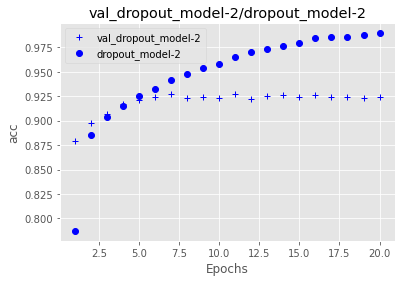

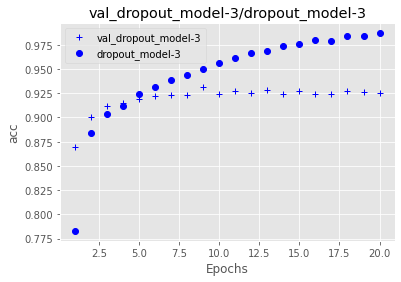

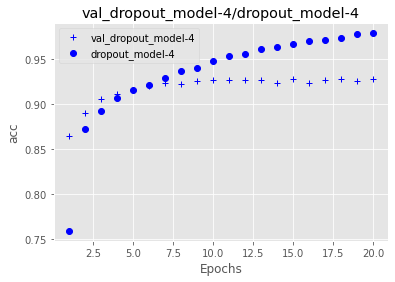

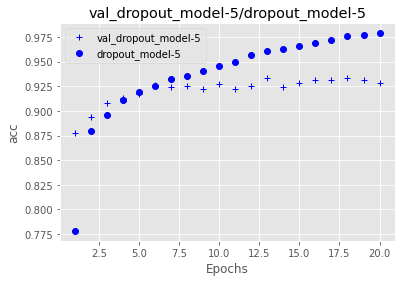

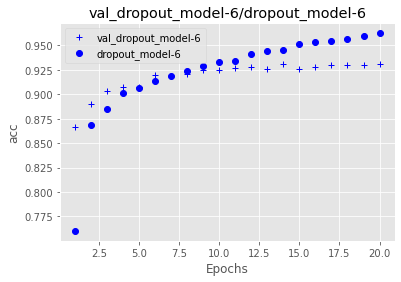

In [75]:
plt_hist(dropout_hist, 'acc')

The accuracy data shows that more dropout layers with a higher frequency stop the validation data from plateauing early.

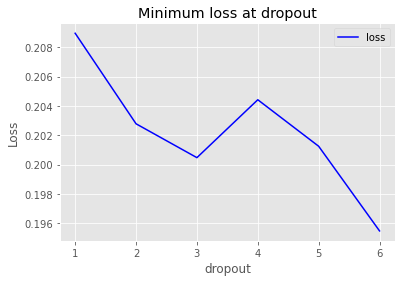

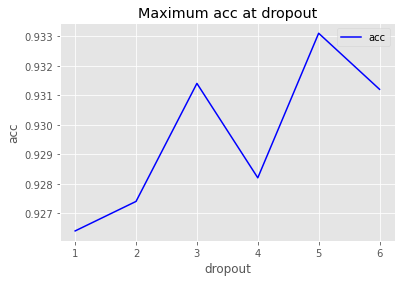

In [76]:
plt_opt_hist(dropout_hist, 'dropout')

there is a steady increase in accuracy with more dropout layers with a dropout frequency of 0.3 performing noticeably better.

In [77]:
dis_opt_results(dropout_hist)

optimal loss = 0.19546672701835632 at dropout_model-6
optimal acc = 0.9330999851226807 at dropout_model-5


The model 'dropout_model-5' has the best validation accuracy achiving 93.3%. this model has three dropout layers with a frequency of 0.3.

In [81]:
keras.models.load_model('models/dropout_model-5.h5').summary()

Model: "dropout_model-5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_189 (Conv2D)          (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 14, 14, 128)       147584    
_________________________________________________________________
dropout_55 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_191 (Conv2D)          (None, 14, 14, 128)       147584    
_________________________________________________________________
dropout_56 (Dropout)         (None, 14, 14, 128)   

I will be using this model configuration moving forward.

## Final model 

I have experimented with scaling up on a low capacity model and have now decided on a final model. That I will evaluate using the test set.

### Training the final model

when training the model I will use the ModelCheckpoint callback function to save the best performing model weights to test with.

In [34]:
final_model = Sequential(name = 'final')
final_model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1)))
final_model.add(MaxPooling2D(pool_size=2))
final_model.add(Dropout(0.3)) 
final_model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
final_model.add(Dropout(0.3))
final_model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
final_model.add(Dropout(0.3))

final_model.add(Flatten())
final_model.add(Dense(128, activation='relu'))
final_model.add(Dense(10, activation='softmax'))


final_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

final_model.summary()

final_model.save('models/final.h5')

Model: "final"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 128)       0     

In [20]:
checkpoint = ModelCheckpoint(filepath='models/final_best.h5', monitor='val_acc', save_best_only=True)
final_history = final_model.fit(partial_x_train, 
                          partial_y_train,
                          epochs = 20,
                          batch_size = 512,
                          validation_data = (x_val, y_val),
                          callbacks = [checkpoint])

Epoch 1/20
98/98 [==============================] - 819s 8s/step - loss: 0.9350 - acc: 0.6653 - val_loss: 0.3608 - val_acc: 0.8739
Epoch 2/20
98/98 [==============================] - 1010s 10s/step - loss: 0.3480 - acc: 0.8748 - val_loss: 0.2831 - val_acc: 0.8960
Epoch 3/20
98/98 [==============================] - 852s 9s/step - loss: 0.2861 - acc: 0.8947 - val_loss: 0.2724 - val_acc: 0.9003
Epoch 4/20
98/98 [==============================] - 920s 9s/step - loss: 0.2497 - acc: 0.9078 - val_loss: 0.2400 - val_acc: 0.9118
Epoch 5/20
98/98 [==============================] - 994s 10s/step - loss: 0.2236 - acc: 0.9186 - val_loss: 0.2152 - val_acc: 0.9209
Epoch 6/20
98/98 [==============================] - 821s 8s/step - loss: 0.1948 - acc: 0.9300 - val_loss: 0.2169 - val_acc: 0.9188
Epoch 7/20
98/98 [==============================] - 800s 8s/step - loss: 0.1824 - acc: 0.9329 - val_loss: 0.1986 - val_acc: 0.9275
Epoch 8/20
98/98 [==============================] - 867s 9s/step - loss: 0.1666 

In [21]:
np.save('results/final.npy', final_history.history) 

### Test final model
I will load the weights from the epoch that achieves the best accuracy on the validation set then evaluate the accuracy of the model with the test set.

In [22]:
final_model.load_weights('models/final_best.h5')

final_model.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 43s 137ms/step - loss: 0.2363 - acc: 0.9241


[0.23625393211841583, 0.9240999817848206]

the final model achieves an accuracy of 92.4% on the test set.

In [35]:
final_model.load_weights('models/final_best.h5')

### Prediction


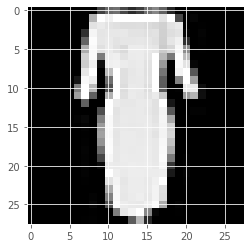

Ground truth = Dress
prediction = Dress


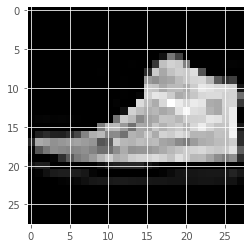

Ground truth = Sneaker
prediction = Sneaker


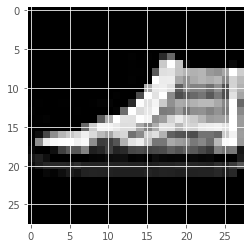

Ground truth = Sneaker
prediction = Sneaker


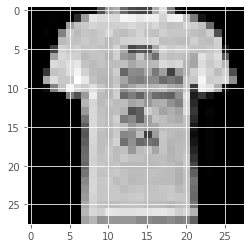

Ground truth = T-shirt/top
prediction = T-shirt/top


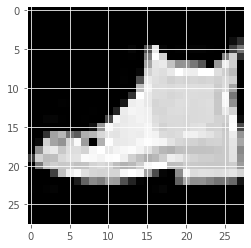

Ground truth = Ankle boot
prediction = Ankle boot


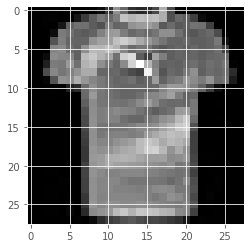

Ground truth = T-shirt/top
prediction = T-shirt/top


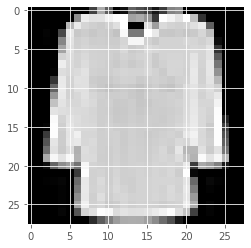

Ground truth = Shirt
prediction = Shirt


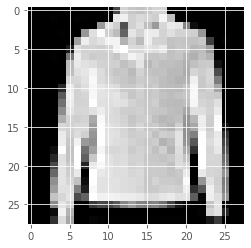

Ground truth = Coat
prediction = Coat


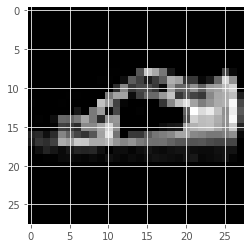

Ground truth = Sandal
prediction = Sandal


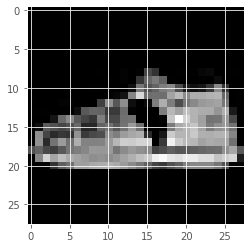

Ground truth = Sandal
prediction = Sandal


In [166]:
rnd = np.random.randint(10000, size=(10))

for x in rnd:
    plt.imshow(np.squeeze(x_test[x]))
    plt.show()
    print("Ground truth = " + labels[np.where(y_test[x]==1)[0][0]])
    y = np.argmax(final_model.predict(np.expand_dims(x_test[x], axis=0)))   
    print("prediction = " + labels[y])

### Prediction using my own image

<class 'PIL.PngImagePlugin.PngImageFile'>
(1287, 1287)


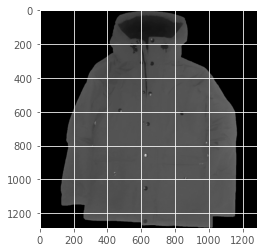

In [204]:
test_image_original = Image.open('test_image_original.png')
plt.imshow(test_image_original)
print(type(test_image_original))
print(test_image_original.size)

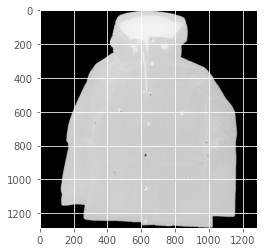

In [205]:
test_image_original_invert = Image.open('test_image_original_invert.png')
plt.imshow(test_image_original_invert)

<class 'numpy.ndarray'>
(28, 28)


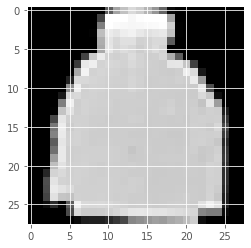

In [206]:
test_image = Image.open('test_image.png')
test_image = test_image.convert('L')
test_image = np.asarray( test_image, dtype="int32" )
plt.imshow(test_image)
print(type(test_image))
print(test_image.shape)

In [207]:
test_image = np.expand_dims(test_image, axis=0)

test_image = test_image.reshape(test_image.shape[0], 28, 28, 1)

test_image = test_image.astype('float32') / 255

Ground truth = Coat
prediction = Coat


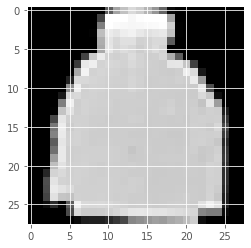

In [208]:
plt.imshow(np.squeeze(test_image))

print("Ground truth = Coat")
y = np.argmax(final_model.predict(test_image))   
print("prediction = " + labels[y])

# pretrained models
I will now use pretrained models along with my own dense classifying layers. these models have usually been trained on millions of images and if data set is general enough, then the features learned by the pretrained network can be repurposed.

## Converting images 
the pretrained CNNs that I have chosen only except images with three channels and with a height and width of at least 32 x 32 so I will need to convert my dataset to be able to use them.

In [9]:
rgb_partial_x_train = np.repeat(partial_x_train, 3, -1)
rgb_x_val = np.repeat(x_val, 3, -1)
rgb_x_test = np.repeat(x_test, 3, -1)
print(rgb_partial_x_train.shape)
print(rgb_x_val.shape)
print(rgb_x_test.shape)

(50000, 28, 28, 3)
(10000, 28, 28, 3)
(10000, 28, 28, 3)


this method duplicates the one channel grayscale value across three channels.

In [10]:
vgg19_partial_x_train = image.resize(rgb_partial_x_train, [32,32])
vgg19_x_val = image.resize(rgb_x_val, [32,32])
vgg19_x_test = image.resize(rgb_x_test, [32,32])
print(vgg19_partial_x_train.shape)
print(vgg19_x_val.shape)
print(vgg19_x_test.shape)
plt.imshow(vgg19_x_test[200])

AttributeError: module 'matplotlib.image' has no attribute 'resize'

(50000, 71, 71, 3)
(10000, 71, 71, 3)
(10000, 71, 71, 3)


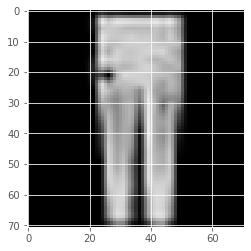

In [10]:
xcep_partial_x_train = image.resize(rgb_partial_x_train, [71, 71])
xcep_x_val = image.resize(rgb_x_val, [71, 71])
xcep_x_test = image.resize(rgb_x_test, [71, 71])
print(xcep_partial_x_train.shape)
print(xcep_x_val.shape)
print(xcep_x_test.shape)
plt.imshow(xcep_x_test[200])

## Vgg19
![picture](https://miro.medium.com/max/2400/1*6U9FJ_se7SIuFKJRyPMHuA.png)

The VGG19 network is very large consisting of 19 weighted layers using a 3x3 kernel an 4 max pooling layers. the model has been trained on the ImageNet dataset.


In [106]:
vgg19_conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))

vgg19_conv_base.trainable = False

vgg19_conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [107]:
vgg19_model = Sequential(name = 'vgg19')
vgg19_model.add(vgg19_conv_base)
vgg19_model.add(Flatten())
vgg19_model.add(Dense(128, activation='relu'))
vgg19_model.add(Dense(10, activation='softmax'))

vgg19_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

vgg19_model.summary()

vgg19_model.save('models/vgg19.h5')

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_77 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_167 (Dense)            (None, 128)               65664     
_________________________________________________________________
dense_168 (Dense)            (None, 10)                1290      
Total params: 20,091,338
Trainable params: 66,954
Non-trainable params: 20,024,384
_________________________________________________________________


In [108]:
checkpoint = ModelCheckpoint(filepath='models/vgg19_best.h5', monitor='val_acc', save_best_only=True)
vgg19_history = vgg19_model.fit(vgg19_partial_x_train, 
                          partial_y_train,
                          epochs = 20,
                          batch_size = 512,
                          validation_data = (vgg19_x_val, y_val),
                          callbacks = [checkpoint])

Epoch 1/20
98/98 [==============================] - 1979s 20s/step - loss: 1.3551 - acc: 0.5715 - val_loss: 0.5852 - val_acc: 0.7953
Epoch 2/20
98/98 [==============================] - 1770s 18s/step - loss: 0.5754 - acc: 0.7953 - val_loss: 0.5060 - val_acc: 0.8191
Epoch 3/20
98/98 [==============================] - 1831s 19s/step - loss: 0.5051 - acc: 0.8204 - val_loss: 0.4666 - val_acc: 0.8362
Epoch 4/20
98/98 [==============================] - 1705s 17s/step - loss: 0.4656 - acc: 0.8327 - val_loss: 0.4452 - val_acc: 0.8419
Epoch 5/20
98/98 [==============================] - 1568s 16s/step - loss: 0.4421 - acc: 0.8390 - val_loss: 0.4316 - val_acc: 0.8474
Epoch 6/20
98/98 [==============================] - 1576s 16s/step - loss: 0.4254 - acc: 0.8478 - val_loss: 0.4182 - val_acc: 0.8483
Epoch 7/20
98/98 [==============================] - 1568s 16s/step - loss: 0.4150 - acc: 0.8524 - val_loss: 0.4096 - val_acc: 0.8523
Epoch 8/20
98/98 [==============================] - 1590s 16s/step - 

In [109]:
np.save('results/vgg19.npy', vgg19_history.history) 

In [110]:
vgg19_model.load_weights('models/vgg19_best.h5')

vgg19_model.evaluate(vgg19_x_test, y_test, verbose=1)

313/313 [==============================] - 278s 888ms/step - loss: 0.3958 - acc: 0.8608


VGG19 achieves an accuracy of 86% this is a decrease in accuracy from my own model I believe this is because VGG19 is mor adapted to images with 3 channels and a higher pixel density and although I am rescaling and repeating one channel three times the necessary information is still not present.

## Xception
![picture](https://miro.medium.com/max/2400/1*hOcAEj9QzqgBXcwUzmEvSg.png)
Xception is based on the inception-V3 model in other words it is an extreme version of inception. The idea behind the Inception module is independently look at cross-channel correlations and at spatial correlations. the Xception model uses a modified depth wise convolution that is a pointwise convolution followed by a standard depthwise convolution.
 

In [11]:
xcep_conv_base = Xception(include_top=False,
                    weights="imagenet",
                    input_shape=(71, 71, 3))

xcep_conv_base.trainable = False

xcep_conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 71, 71, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 35, 35, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 35, 35, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 35, 35, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [13]:
xcep_model = Sequential(name = 'xception')
xcep_model.add(xcep_conv_base)
xcep_model.add(Flatten())
xcep_model.add(Dense(128, activation='relu'))
xcep_model.add(Dense(10, activation='softmax'))

xcep_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

xcep_model.summary()

xcep_model.save('models/xception.h5')


Model: "xception"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2359424   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 23,222,194
Trainable params: 2,360,714
Non-trainable params: 20,861,480
_________________________________________________________________


In [18]:
xcep_model.load_weights('models/xception_best.h5')

xcep_model.evaluate(xcep_x_test, y_test, verbose=1)

313/313 [==============================] - 356s 1s/step - loss: 0.3966 - acc: 0.8734


Xception model shows a reduced accuracy archiving 87% I believe this is because depthwise convolution is specifically suited for multi-channel images.

# Conclusion
After expanding my low-capacity model to the point of overfitting, I believe that I have found a model that is flexible enough to create meaningful predictions, from the data set but not to complex that it unable to generalise.

I have also experimented with pretrained models that performed noticeably worse than my own model. I believe that this is because the images in the dataset I have chosen are too low a resolution and the more complex pretrained models are unable to find meaningful abstractions.

CNN's are extremely powerful models for image classification problems I was able to achieve an accuracy of 92.4% on a relatively small dataset. this is an improvement of 824% over a random bassline.

# References 

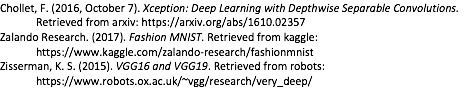